In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from collections import Counter
from Levenshtein import distance as lev

In [2]:
# source:https://stackoverflow.com/questions/2460177/edit-distance-in-python
# 定义编辑距离
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [3]:
def agendaDissim(s1,s2):
    U = set(s1).union(set(s2))
    I = set(s1).intersection(set(s2))
    if U == I:
        metric = 0
    else:
        metric = 100
    return metric

In [ ]:
# 考虑更粗粒度的序列（参照allahviranloo2016的设定，以10分钟为间隔）
def simplify_seq(trajectory):
    seq_10min = []
    for i in range(0,len(trajectory),10):
        data = trajectory[i:i+10]
        ptype = Counter(data).most_common(1)[0][0]
        seq_10min.append(ptype)
    return seq_10min

In [88]:
trajectory = np.loadtxt('data/trajectory_in_week_3ptype_2019_58.txt')

In [90]:
trajectory_10min = []
for data in trajectory:
    trajectory_10min.append(simplify_seq(data))

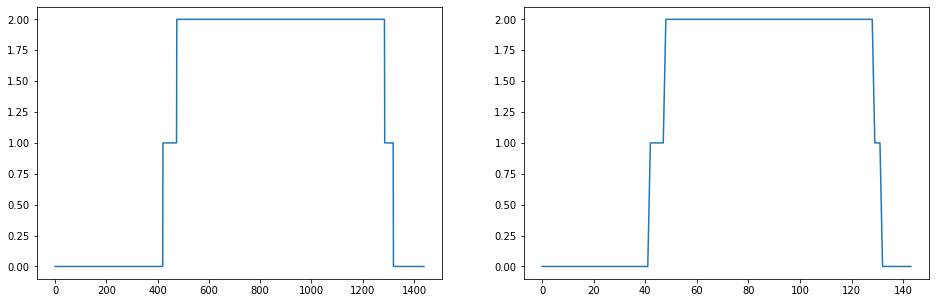

In [21]:
# 画个图看看
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(trajectory[1])
ax[1].plot(trajectory_10min[1])

## 成对距离计算

In [11]:
def mix_dist(x, y , w1=0.9, w2=0.1):
    return w1*lev(string_trans(x),string_trans(y)) + w2*agendaDissim(x,y)

In [9]:
def string_trans(data):
    data = np.array(data).astype('int')
    str1 = ""
    for val in data:
        str1 += str(val)  
    return str1

In [10]:
trajectory_10min_100 = trajectory_10min[0:101]

In [87]:
D = pairwise_distances(trajectory_10min_100,metric=mix_dist,n_jobs=-1)

## AGNES聚类

In [84]:
AGNES = AgglomerativeClustering(n_clusters=5,
                                affinity='precomputed',
                                linkage='complete')
agnes = AGNES.fit(D)

In [81]:
labels = agnes.labels_
labels = labels.reshape(len(labels))

In [82]:
pd.value_counts(labels)

0    50
3    36
1    11
2     3
4     1
dtype: int64

In [73]:
trajectory_10min_100 = np.array(trajectory_10min_100)
trajectory_0 = trajectory_10min_100[np.where(agnes.labels_==0)]
trajectory_1 = trajectory_10min_100[np.where(agnes.labels_==1)]
trajectory_2 = trajectory_10min_100[np.where(agnes.labels_==2)]
trajectory_3 = trajectory_10min_100[np.where(agnes.labels_==3)]
print(len(trajectory_0),len(trajectory_1),len(trajectory_2),len(trajectory_3))

11 36 3 2


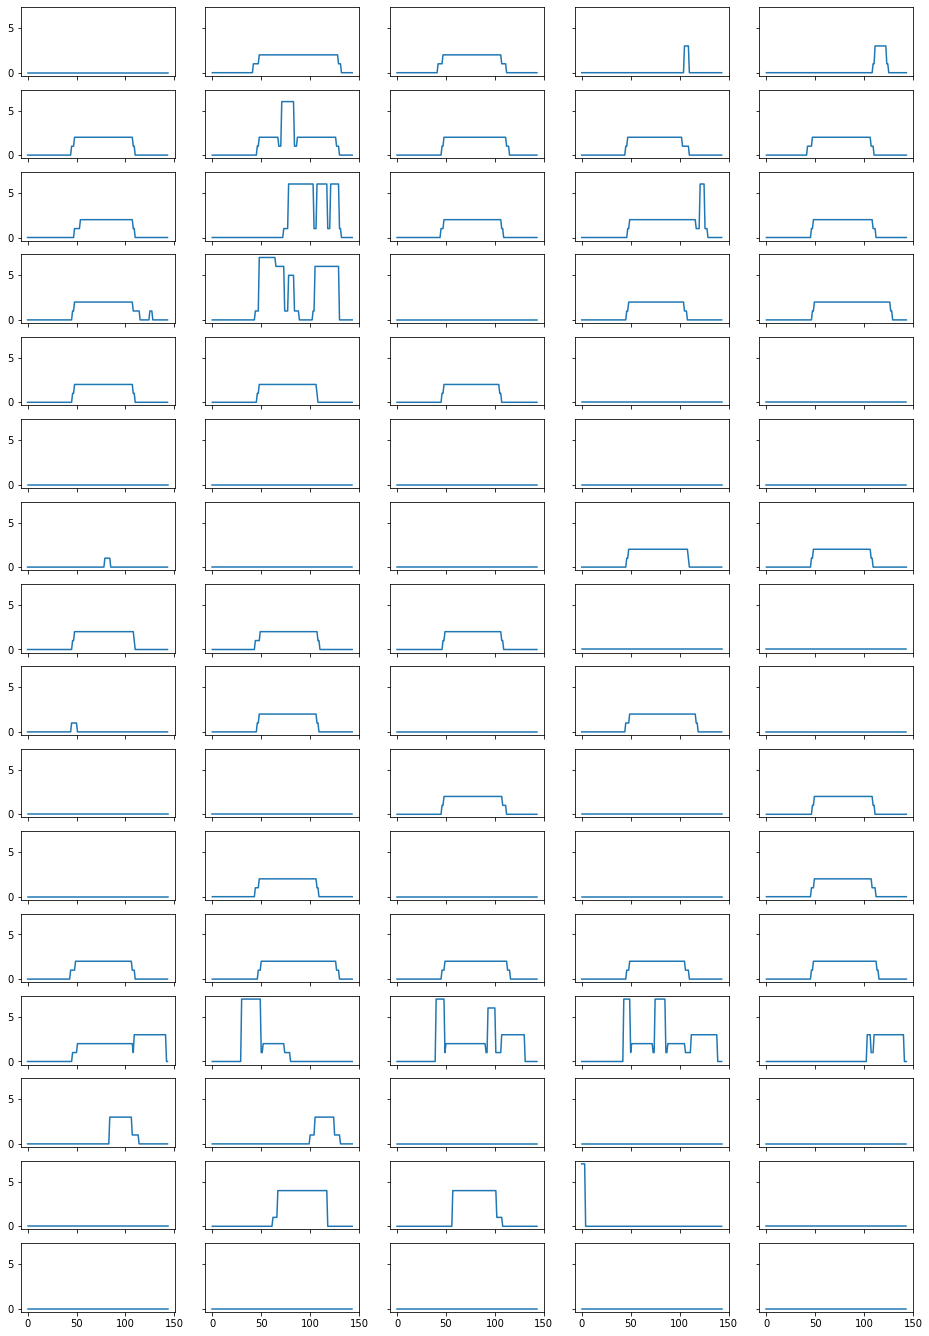

In [24]:
 fig, ax = plt.subplots(16, 5, sharex=True, sharey=True, figsize=(16,24))
for i in range(16):
    for j in range(5):
        flag = i * 5 + j
        ax[i,j].plot(trajectory_0[flag])

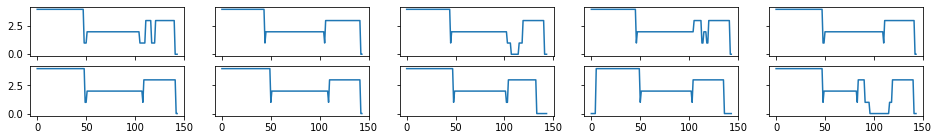

In [29]:
 fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(16,2))
for i in range(2):
    for j in range(5):
        flag = i * 5 + j
        ax[i,j].plot(trajectory_1[flag])

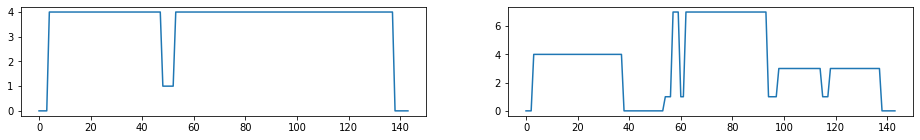

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16,2))
ax[0].plot(trajectory_2[0])
ax[1].plot(trajectory_3[0])

## 亲和力传播+kmeans（k-means的距离很难修改）

In [13]:
from sklearn.cluster import KMeans, AffinityPropagation

In [39]:
#计算affinity propagation
af = AffinityPropagation(damping=0.6,max_iter=200,preference=-1000,random_state=0).fit(trajectory_10min_100)

In [40]:
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

In [41]:
cluster_centers_indices

array([ 1, 16, 20, 25, 66, 70, 71], dtype=int64)